In [1]:
"""Selección de Características para mapa UMAP de Pasos y Poses"""
import sys
import multiprocessing as mp
from copy import deepcopy
from itertools import product
import numpy as np
import config_dodo
import config
from utilities import read_pickle, write_pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import entropy
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
import plotly.express as px
import plotly.graph_objects as go
import pylab
import scipy.cluster.hierarchy as spc
import scipy.spatial.distance as spd
from sklearn.preprocessing import scale
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt
from scipy.stats import trim_mean
import datashader.bundling as bd
from bundle_edges import hammer_connectivity, _get_embedding
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from fastkde import fastKDE
from skimage.filters import gaussian
import statsmodels.api as sm

(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses").mkdir(parents=True, exist_ok=True)
sns.set_context("paper", font_scale=2.0)
sns.set_style(
    "ticks",
    {
        "text.color": "k",
        "axes.edgecolor": "k",
        "axes.labelcolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)

/home/alvaro/.local/lib/python3.8/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
path_stats_paw_avg = config_dodo.MTR_PATH / f"Step/step_statistics_paw_average.pickle"
stats_paw_avg = read_pickle(path_stats_paw_avg)

In [3]:
stp_sample_path = config_dodo.STP_PATH / "stp_sample.pickle"
stp_sample = read_pickle(stp_sample_path)
emb_stp_path = config_dodo.EMB_PATH / "emb_stp_sample.pickle"
emb_stp = read_pickle(emb_stp_path)
out_stp_path = config_dodo.OUT_PATH / "out_stp_sample.pickle"
out_stp = read_pickle(out_stp_path)
knn_stp_path = config_dodo.EMB_PATH / "knn_fit_stp.pickle"
knn_stp = read_pickle(knn_stp_path)
edg_stp_path = config_dodo.EMB_PATH / "edg_stp_sample.pickle"
edg_stp = read_pickle(edg_stp_path)
loc_dim_stp_path = config_dodo.EMB_PATH / "loc_dim_stp_sample.pickle"
loc_dim_stp = read_pickle(loc_dim_stp_path)
out_stp_all = read_pickle(config_dodo.OUT_PATH / "out_stp_all.pickle")
label_stp_all = read_pickle(config_dodo.LAB_PATH / "lab_stp_all.pickle")
label_wav_all = read_pickle(config_dodo.LAB_PATH / "lab_wav_all.pickle")

Thu Feb  3 14:51:17 2022 Building and compiling search function


In [4]:
sample_idx_stp = []
sample_idx_wav = []
lat_sum = 0
for key in config_dodo.KEY_LIST:
    name = config_dodo.SUBJECT_NAME.format(*key)
    pickle_end = name + ".pickle"
    idx = read_pickle(config_dodo.IDX_PATH / f"idx_{pickle_end}")
    sample_idx_stp.append(idx + lat_sum)
    sample_idx_wav.append(idx[::config.EMB_WAV_SUBSAMPLE_EVERY] + lat_sum)
    lat = read_pickle(config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}")
    lat_sum += lat
sample_idx_stp = np.concatenate(sample_idx_stp)
sample_idx_wav = np.concatenate(sample_idx_wav)
sample_stp_in_wav = np.isin(sample_idx_stp, sample_idx_wav, assume_unique=True)

long_data = read_pickle(config_dodo.LAB_PATH / "label_long_data.pickle")
group_to_label_stp = {group: label for group, label in long_data[["sequence_group_stp", "label_stp"]].values}
group_to_label_stp
next_group_stp = long_data.iloc[sample_idx_stp]["sequence_group_stp"] + 1
next_group_stp_label = next_group_stp.map(group_to_label_stp).fillna(method="bfill").fillna(method="ffill").to_numpy()
previous_group_stp = long_data.iloc[sample_idx_stp]["sequence_group_stp"] - 1
previous_group_stp_label = previous_group_stp.map(group_to_label_stp).fillna(method="bfill").fillna(method="ffill").to_numpy()
seq_data_stp = read_pickle(config_dodo.LAB_PATH / "label_sequence_data_stp.pickle")
seq_idx_stp = long_data.iloc[sample_idx_stp]["sequence_group_stp"].to_numpy() - 1
duration_stp = seq_data_stp.iloc[seq_idx_stp]["duration"].to_numpy() * 0.01

In [5]:
m, d, t = (297, 5, 2)
name = config_dodo.SUBJECT_NAME.format(m, d, t)
pickle_end = name + ".pickle"
path_qnt = config_dodo.QNT_PATH / f"qnt_xy_{pickle_end}"
xys = read_pickle(path_qnt)
path_events = config_dodo.MTR_PATH / f"Step/step_events_{pickle_end}"
step_events = read_pickle(path_events)
path_statistics = config_dodo.MTR_PATH / f"Step/step_statistics_{pickle_end}"
step_statistics = read_pickle(path_statistics)
path_latency = config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}"
latency = read_pickle(path_latency)
path_stp = config_dodo.STP_PATH / f"stp_{pickle_end}"
stp = read_pickle(path_stp)
path_stp_scaler = config_dodo.STP_PATH / "standard_scaler_fit_stp.pickle"
stp_scaler = read_pickle(path_stp_scaler)
path_stp_pca = config_dodo.STP_PATH / "pca_fit_stp.pickle"
stp_pca = read_pickle(path_stp_pca)
path_subsample_idx = config_dodo.IDX_PATH / f"idx_{pickle_end}"
subsample_idx = read_pickle(path_subsample_idx)
path_ang = config_dodo.ANG_PATH / f"ang_{pickle_end}"
ang = read_pickle(path_ang)
path_ang_scaler = config_dodo.ANG_PATH / f"standard_scaler_fit_ang.pickle"
ang_scaler = read_pickle(path_ang_scaler)
path_wav = config_dodo.WAV_PATH / f"wav_{pickle_end}"
wav = read_pickle(path_wav)
path_wav_pca = config_dodo.WAV_PATH / "pca_fit_wav.pickle"
wav_pca = read_pickle(path_wav_pca)
path_xys = config_dodo.QNT_PATH / f"qnt_xy_{pickle_end}"
xys = read_pickle(path_xys)[:latency]

In [6]:
print(out_stp_all.shape[0])
print(out_stp_all.shape[0] * 2 / 100 / (60 * 60))
print(out_stp.shape[0])
print(out_stp.shape[0] / out_stp_all.shape[0] * 100)

5458552
30.32528888888889
509995
9.34304555493838


In [6]:
plt.figure(figsize=(18, 2.5))
orden = {
    0: "mu_y1",
    2: "mu_y2",
    4: "mu_amp",
    6: "mu_dy_max",
    8: "mu_abs_delta_phi",
    10: "mu_freq",
    1: "sigma_y1",
    3: "sigma_y2",
    5: "sigma_amp",
    7: "sigma_dy_max",
    9: "sigma_abs_delta_phi",
    11: "sigma_freq",
    12: "event_y1",
    13: "event_y2",
    14: "event_amp",
    15: "event_dy_max",
    16: "event_abs_delta_phi",
    17: "event_freq",
    18: "x_paws_diff",
    19: "x_paws_mean",
    20: "x_other_tail",
    21: "x_other_back",
    22: "x_other_nose",
    23: "x_center_of_mass",
    24: "y_paws_diff",
    25: "y_paws_mean",
    26: "y_other_tail",
    27: "y_other_back",
    28: "y_other_nose",
    29: "y_center_of_mass",
}
n_components = 4
vext = np.abs(stp_pca.components_[:n_components, list(orden.keys())]).max()
plt.imshow(stp_pca.components_[:n_components, list(orden.keys())][::-1], aspect="auto", cmap="bwr", vmin=-vext, vmax=vext, origin="lower")
ax = plt.gca()
cax = plt.colorbar(pad=0.01)
cax.set_label(label="Pesos PCA", labelpad=10)
cax.ax.set_frame_on(False)
cax.ax.tick_params(axis="both", which="both", length=0)
# plt.hlines(np.arange(1, n_components) - 0.5, *ax.get_xlim(), colors="1", lw=4)
# plt.vlines(6 * np.arange(1, 5) - 0.5, *ax.get_ylim(), colors="0.5", lw=2)
plt.vlines(6 * np.arange(1, 5) - 0.5, *ax.get_ylim(), colors="1", lw=2)
plt.hlines(np.arange(1, n_components) - 0.5, *ax.get_xlim(), colors="1", lw=2)
ax.set_yticks(range(n_components))
ax.set_yticklabels([f"PC{i + 1}" for i in np.arange(n_components)[::-1]])
stp_nombres = [
    r"$\hat{\mu}_\xi$",
    r"$\hat{\sigma}_\xi$",
    r"$\langle \xi \rangle_{\mathrm{patas}}$",
    r"coordenada $x$",
    r"coordenada $y$",
]
ax.set_xticks(np.arange(3, 30, 6) - 0.5)
ax.set_xticklabels(stp_nombres)
ax.xaxis.set_ticks_position("top")
ax.tick_params(axis="both", which="both", length=0)
stp_feats = [
    "altura mín.",
    "altura máx.",
    "amplitud",
    "velocidad",
    "desfasaje",
    "frecuencia",
]
for i, feature in enumerate(stp_feats):
    # plt.text(13 + i - 0.5, -0.6, feature, va="top", ha="right", rotation=45)
    plt.text(1 + i - 0.5, -0.6, feature, va="top", ha="right", rotation=45)
stp_markers = [
    "dif. patas",
    "prom. patas",
    "cola",
    "espalda",
    "nariz",
    "CM",
]
for i, marker in enumerate(stp_markers):
    # plt.text(25 + i - 0.5, -0.6, marker, va="top", ha="right", rotation=45)
    plt.text(19 + i - 0.5, -0.6, marker, va="top", ha="right", rotation=45)
ax.set_frame_on(False)
# plt.show()
plt.savefig("stp_pca.png", dpi=400, bbox_inches="tight")
plt.savefig("stp_pca.pdf", dpi=400, bbox_inches="tight")
plt.close()

print("Varianza explicada por cada componente:")
print(*[f"PC{i+1}: {v:.2f}" for i, v in enumerate(stp_pca.explained_variance_ratio_[:n_components])])

print("Varianza total explicada por estas componentes:")
print(f"{stp_pca.explained_variance_ratio_[:n_components].sum():.2f}")

Varianza explicada por cada componente:
PC1: 0.28 PC2: 0.12 PC3: 0.07 PC4: 0.06
Varianza total explicada por estas componentes:
0.53


In [7]:
"""Steps and Poses features"""
"""Primero los mu, sigma de las características"""
"""Después los promedios de los eventos entre las patas izq y der"""
"""Al último, las posiciones relativas de marcadores"""
STP_IDX_NAMES = {
    0: "mu_y1",
    1: "sigma_y1",
    2: "mu_y2",
    3: "sigma_y2",
    4: "mu_amp",
    5: "sigma_amp",
    6: "mu_dy_max",
    7: "sigma_dy_max",
    8: "mu_abs_delta_phi",
    9: "sigma_abs_delta_phi",
    10: "mu_freq",
    11: "sigma_freq",
    12: "event_y1",
    13: "event_y2",
    14: "event_amp",
    15: "event_dy_max",
    16: "event_abs_delta_phi",
    17: "event_freq",
    18: "x_paws_diff",
    19: "x_paws_mean",
    20: "x_other_tail",
    21: "x_other_back",
    22: "x_other_nose",
    23: "x_center_of_mass",
    24: "y_paws_diff",
    25: "y_paws_mean",
    26: "y_other_tail",
    27: "y_other_back",
    28: "y_other_nose",
    29: "y_center_of_mass",
}

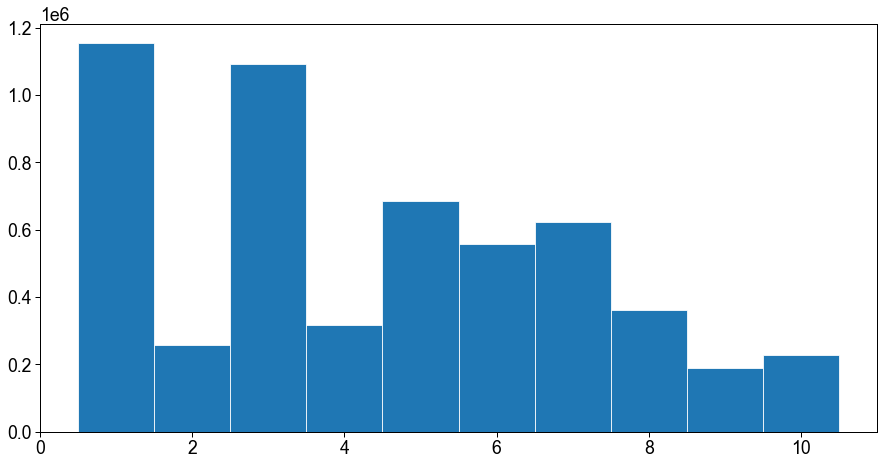

In [8]:
plt.figure(figsize=(15, 7.5))
# plt.hist(stp_sample[:, 0]) # mu_yi
# plt.hist(stp_sample[:, 4]) # mu_amp
# plt.hist(stp_sample[:, 24]) # y_paws_diff
plt.hist(label_stp_all, bins=np.arange(0.5, 11.5)) # labels
plt.show()
plt.close()

In [10]:
def get_step_indices(latency_offset, events, hindpaw):
    """Returns step global indices."""
    # indices = events.query("hindpaw == @hindpaw")["t_dy_max"].to_numpy()
    indices = events.query("hindpaw == @hindpaw")["t_y1"].to_numpy()
    return indices + latency_offset
left_steps = []
right_steps = []
latency_sum = 0
for key in config_dodo.KEY_LIST:
    name = config_dodo.SUBJECT_NAME.format(*key)
    pickle_end = name + ".pickle"
    latency = read_pickle(config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}")
    events = read_pickle(config_dodo.MTR_PATH / f"Step/step_events_{pickle_end}")
    left_steps.append(get_step_indices(latency_offset=latency_sum, events=events, hindpaw="left"))
    right_steps.append(get_step_indices(latency_offset=latency_sum, events=events, hindpaw="right"))
    latency_sum += latency
left_steps = np.concatenate(left_steps)
right_steps = np.concatenate(right_steps)

In [11]:
left_kde_stps = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "left_kde_stps.pickle")
right_kde_stps = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "right_kde_stps.pickle")
hp_kde_stps = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "hp_kde_stps.pickle")
lp_kde_stps = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "lp_kde_stps.pickle")
days_kde_stps = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "days_kde_stps.pickle")

In [12]:
def get_steps_poses_features_gaussian_convolution(img, emb_sigma):
    """Convolve stpelet outcomes density with gaussian kernel."""
    sigma = (
        emb_sigma
        * config.WAT_RESOLUTION
        / (config.WAT_EMB_STP_MAIN[1] - config.WAT_EMB_STP_MAIN[0])
    )
    img_smooth = gaussian(img, sigma=sigma)
    img_smooth /= np.sum(img_smooth)
    return img_smooth

emb_sigma = 0.5
right_pdf_stps = get_steps_poses_features_gaussian_convolution(right_kde_stps, emb_sigma)
left_pdf_stps = get_steps_poses_features_gaussian_convolution(left_kde_stps, emb_sigma)

max_pdf_stps = np.maximum(right_pdf_stps.max(), left_pdf_stps.max())
right_pdf_stps /= max_pdf_stps
left_pdf_stps /= max_pdf_stps

hp_pdf_stps = get_steps_poses_features_gaussian_convolution(hp_kde_stps, emb_sigma)
lp_pdf_stps = get_steps_poses_features_gaussian_convolution(lp_kde_stps, emb_sigma)

max_pdf_stps = np.maximum(hp_pdf_stps.max(), lp_pdf_stps.max())
hp_pdf_stps /= max_pdf_stps
lp_pdf_stps /= max_pdf_stps

days_pdf_stps = []
for i in range(len(days_kde_stps)):
    day_pdf_stps = get_steps_poses_features_gaussian_convolution(days_kde_stps[i], emb_sigma)
    days_pdf_stps.append(day_pdf_stps)
max_pdf_stps = np.max(days_pdf_stps)
for i in range(len(days_kde_stps)):
    days_pdf_stps[i] /= max_pdf_stps

In [13]:
# emb_sigma = 0.5
# axes_stps = [
#     np.linspace(*config.WAT_EMB_STP_MAIN, config.WAT_RESOLUTION + 1)
#     for _ in range(2)
# ]
# right_out_stps = out_stp_all[right_steps]
# left_out_stps = out_stp_all[left_steps]
# right_kde_stps, _ = fastKDE.pdf(
#     right_out_stps[:, 0],
#     right_out_stps[:, 1],
#     axes=axes_stps,
# )
# left_kde_stps, _ = fastKDE.pdf(
#     left_out_stps[:, 0],
#     left_out_stps[:, 1],
#     axes=axes_stps,
# )

# right_pdf_stps = get_steps_poses_features_gaussian_convolution(right_kde_stps, emb_sigma)
# left_pdf_stps = get_steps_poses_features_gaussian_convolution(left_kde_stps, emb_sigma)

# max_pdf_stps = np.maximum(right_pdf_stps.max(), left_pdf_stps.max())
# right_pdf_stps /= max_pdf_stps
# left_pdf_stps /= max_pdf_stps

# hp_sample_idx_stp = long_data.iloc[sample_idx_stp].query("mouse in @config_dodo.HP_MOUSE_LIST").index
# lp_sample_idx_stp = long_data.iloc[sample_idx_stp].query("mouse in @config_dodo.LP_MOUSE_LIST").index
# hp_out_stps = out_stp_all[hp_sample_idx_stp]
# lp_out_stps = out_stp_all[lp_sample_idx_stp]
# hp_kde_stps, _ = fastKDE.pdf(
#     hp_out_stps[:, 0],
#     hp_out_stps[:, 1],
#     axes=axes_stps,
# )
# lp_kde_stps, _ = fastKDE.pdf(
#     lp_out_stps[:, 0],
#     lp_out_stps[:, 1],
#     axes=axes_stps,
# )

# hp_pdf_stps = get_steps_poses_features_gaussian_convolution(hp_kde_stps, emb_sigma)
# lp_pdf_stps = get_steps_poses_features_gaussian_convolution(lp_kde_stps, emb_sigma)

# max_pdf_stps = np.maximum(hp_pdf_stps.max(), lp_pdf_stps.max())
# hp_pdf_stps /= max_pdf_stps
# lp_pdf_stps /= max_pdf_stps

# days_kde_stps = []
# for d in config_dodo.DAY_LIST:
#     day_sample_idx_stp = long_data.iloc[sample_idx_stp].query("day == @d").index
#     day_out_stps = out_stp_all[day_sample_idx_stp]
#     day_kde_stps, _ = fastKDE.pdf(
#         day_out_stps[:, 0],
#         day_out_stps[:, 1],
#         axes=axes_stps,
#     )
#     days_kde_stps.append(day_kde_stps)

# days_pdf_stps = []
# for i in range(len(days_kde_stps)):
#     day_pdf_stps = get_steps_poses_features_gaussian_convolution(days_kde_stps[i], emb_sigma)
#     days_pdf_stps.append(day_pdf_stps)
# max_pdf_stps = np.max(days_pdf_stps)
# for i in range(len(days_kde_stps)):
#     days_pdf_stps[i] /= max_pdf_stps

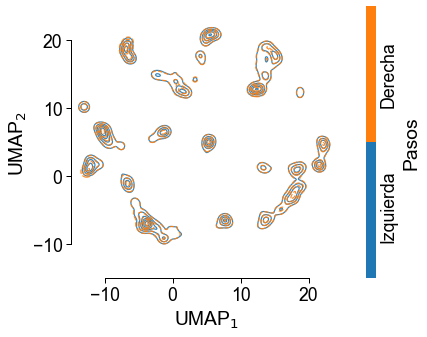

In [42]:
# save_name = "pasos_stp.png"
save_name = "pasos_stp.pdf"
label = "Pasos"
plt.figure(figsize=(6, 5))
plt.contour(left_pdf_stps, alpha=0.9, colors="tab:blue", extent=config.WAT_EMB_STP_MAIN + config.WAT_EMB_STP_MAIN)
plt.contour(right_pdf_stps, alpha=0.9, colors="tab:orange", linestyles="dashed", extent=config.WAT_EMB_STP_MAIN + config.WAT_EMB_STP_MAIN)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(range(1, 3))
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=5)
cbar.ax.set_xlim(-2, 2)
cbar.ax.set_ylim(0.5, 2.5)
cbar.set_ticks([1.25, 2.2])
cbar.set_ticklabels(["Izquierda", "Derecha"])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0, rotation=90)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


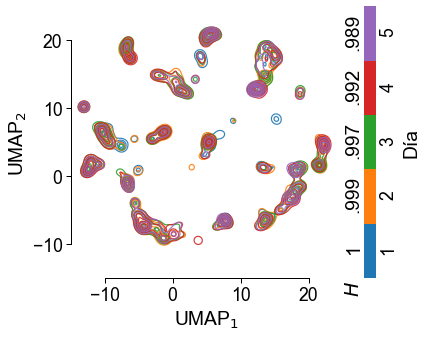

In [43]:
# save_name = "dias_stp.png"
save_name = "dias_stp.pdf"
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
label = "Día"
plt.figure(figsize=(6, 5))
for i in range(len(days_pdf_stps)):
    plt.contour(days_pdf_stps[i], alpha=0.9, colors=colors[i], extent=config.WAT_EMB_STP_MAIN + config.WAT_EMB_STP_MAIN)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(range(1, 6))
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=5)
cbar.ax.set_xlim(-5, 5)
cbar.ax.set_ylim(0.5, 5.5)
cbar.set_ticks(range(1, 6))
cbar.set_ticklabels(range(1, 6))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0, rotation=90)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
ref_entropy = entropy(days_pdf_stps[0].flatten())
x_text = 0.795
y_text_ini = 0.21
y_text_delta = 0.15
plt.figtext(x_text, y_text_ini - y_text_delta * 0.75, r"$H$", ha="center", va="center", rotation=90)
for i in range(5):
    rel_entropy = entropy(days_pdf_stps[i].flatten()) / ref_entropy
    if i == 0:
        plt.figtext(x_text, y_text_ini + i * y_text_delta, "1", ha="center", va="center", rotation=90)
    else:
        plt.figtext(x_text, y_text_ini + i * y_text_delta, f"{rel_entropy:.3f}"[1:], ha="center", va="center", rotation=90)
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


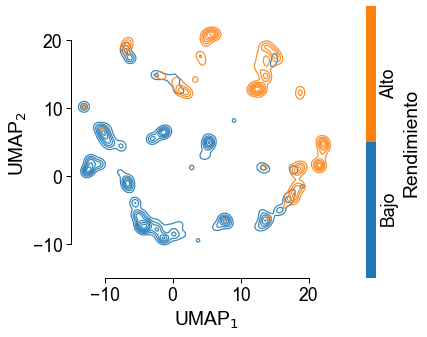

In [44]:
# save_name = "rendimiento_stp.png"
save_name = "rendimiento_stp.pdf"
label = "Rendimiento"
plt.figure(figsize=(6, 5))
plt.contour(lp_pdf_stps, alpha=0.9, colors="tab:blue", extent=config.WAT_EMB_STP_MAIN + config.WAT_EMB_STP_MAIN)
plt.contour(hp_pdf_stps, alpha=0.9, colors="tab:orange", extent=config.WAT_EMB_STP_MAIN + config.WAT_EMB_STP_MAIN)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(range(1, 3))
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=5)
cbar.ax.set_xlim(-2, 2)
cbar.ax.set_ylim(0.5, 2.5)
cbar.set_ticks([1.1, 2])
cbar.set_ticklabels(["Bajo", "Alto"])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0, rotation=90)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [94]:
# write_pickle(left_kde_stps, config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "left_kde_stps.pickle")
# write_pickle(right_kde_stps, config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "right_kde_stps.pickle")
# write_pickle(hp_kde_stps, config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "hp_kde_stps.pickle")
# write_pickle(lp_kde_stps, config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "lp_kde_stps.pickle")
# write_pickle(days_kde_stps, config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / "days_kde_stps.pickle")

In [12]:
# long_data_group = long_data.groupby(["sequence_group_stp"])
# seq_data_stp = pd.concat(
#     [
#         long_data_group[["mouse", "day", "trial", "label_stp", "sequence_group_stp"]]
#         .median()
#         .applymap(int),
#         long_data_group["sequence_group_stp"].count().rename("duration"),
#         long_data_group["sequence_group_stp"]
#         .count()
#         .apply(np.log10)
#         .rename("log_duration"),
#         long_data_group[["local_idx", "global_idx"]].first(),
#     ],
#     axis=1,
# ).reset_index(drop=True)
# write_pickle(seq_data_stp, config_dodo.LAB_PATH / "label_sequence_data_stp.pickle")

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


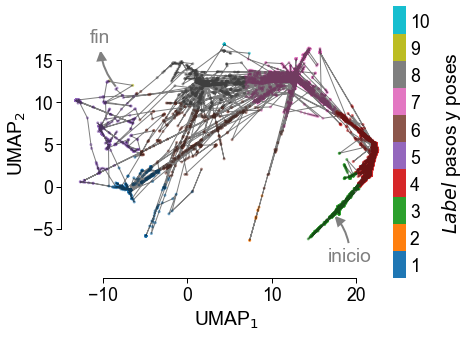

In [41]:
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
color = label_stp_all[see.index]
label = r"$Label$ pasos y poses"
save_name = "label_serie_mapa_stp"
color_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color = np.array(np.vectorize(color_dict.get)(color)).T
plt.figure(figsize=(7, 5))
plt.scatter(*out_stp_all[see.index].T, c=color, s=5, alpha=0.5)
plt.plot(*out_stp_all[see.index].T, c="k", alpha=0.5, lw=1)
xy = out_stp_all[see.index[0]]
plt.annotate(
    "inicio", xy=xy, xytext=xy + (2, -5), ha="center", va="center", color="0.5",
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
xy = out_stp_all[see.index[-1]]
plt.annotate(
    "fin", xy=xy, xytext=xy + (-2, 5), ha="center", va="bottom", color="0.5",
    arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=10)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
plt.xlim(config.WAT_EMB_STP_MAIN)
plt.ylim(config.WAT_EMB_STP_MAIN)
plt.axis("equal")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

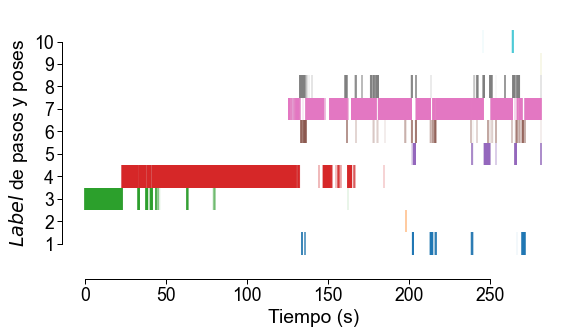

In [40]:
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
ls = label_stp_all[see.index]
save_name = "label_secuencia_stp"
evs = [np.where(ls==l)[0] for l in range(1, 11)]
plt.figure(figsize=(9, 5))
plt.eventplot(evs, colors=cm.tab10(np.linspace(0, 1, 10)), lw=0.1)
plt.gca().set_yticks(range(10))
plt.gca().set_yticklabels(range(1, 11))
plt.ylabel(r"$Label$ de pasos y poses")
plt.xlabel("Tiempo (s)")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

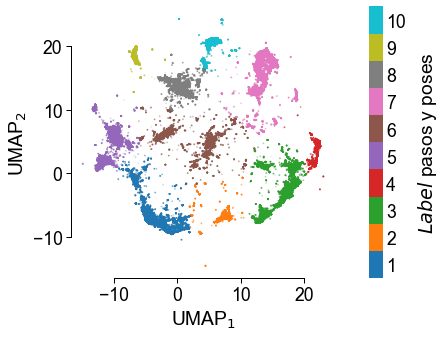

In [22]:
color = label_stp_all[sample_idx_stp]
label = r"$Label$ pasos y poses"
save_name = "label_stp.png"
# color = label_wav_all[sample_idx_stp]
# label = r"$Label$ $wavelets$"
# save_name = "label_contra_stp.png"
# color = next_group_stp_label
# label = r"$Label$ siguiente en la secuencia"
# save_name = "label_siguiente_stp.png"
# color = previous_group_stp_label
# label = r"$Label$ anterior en la secuencia"
# save_name = "label_anterior_stp.png"
plt.figure(figsize=(7, 5))
plt.scatter(*out_stp.T, c=color, cmap="tab10", s=1, alpha=0.1)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=10)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
# plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


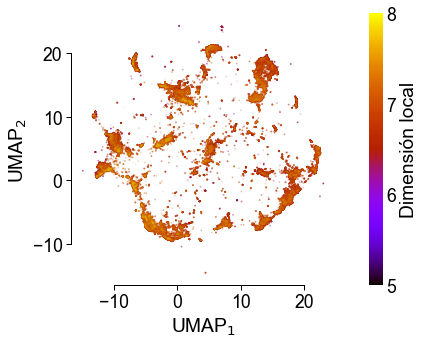

In [23]:
# color = duration_stp
# label = r"Duración $label$ pasos y poses (s)"
# save_name = "label_duracion_stp.png"
color = loc_dim_stp # local dimension
label = "Dimensión local"
save_name = "dimension_local_stp.png"
cmap = "gnuplot"
plt.figure(figsize=(7, 5))
sort_idx = np.argsort(color)
plt.scatter(*out_stp[sort_idx].T, c=color[sort_idx], cmap=cmap, s=1, alpha=0.05)
vmin = np.quantile(color, 0.05)
vmax = np.quantile(color, 0.95)
norm = Normalize(vmin=vmin, vmax=vmax)
mappable = ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label)
cbar.ax.set_frame_on(False)
# cbar.set_ticks(range(5, 9))
# cbar.set_ticklabels(range(5, 9))
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [239]:
color_list = [
    long_data.iloc[sample_idx_stp]["local_idx"].to_numpy() / config.WAV_F_SAMPLING,
    stp_sample[:, 0], # mu_y1
    stp_sample[:, 1], # sigma_y1
    stp_sample[:, 2], # mu_y2
    stp_sample[:, 3], # sigma_y2
    stp_sample[:, 4], # mu_amp
    stp_sample[:, 5], # sigma_amp
    stp_sample[:, 6], # mu_dy_max
    stp_sample[:, 7], # sigma_dy_max
    stp_sample[:, 8], # mu_abs_delta_phi
    stp_sample[:, 9], # sigma_abs_delta_phi
    stp_sample[:, 10], # mu_freq
    stp_sample[:, 11], # sigma_freq
    stp_sample[:, 12], # event_y1
    stp_sample[:, 13], # event_y2
    stp_sample[:, 14], # event_amp
    stp_sample[:, 15], # event_dy_max
    stp_sample[:, 16], # event_abs_delta_phi
    stp_sample[:, 17], # event_freq
    stp_pca.transform(stp_scaler.transform(stp_sample))[:, 0], # PC1
    stp_pca.transform(stp_scaler.transform(stp_sample))[:, 1], # PC2
    stp_pca.transform(stp_scaler.transform(stp_sample))[:, 2], # PC3
    stp_pca.transform(stp_scaler.transform(stp_sample))[:, 3], # PC4
    loc_dim_stp, # local dimension
    duration_stp, # duracion labels pasos y poses
]
label_list = [
    "Tiempo en la prueba (s)",
    "Altura mínima promedio (mm)",
    "Altura mínima desviación (mm)",
    "Altura máxima promedio (mm)",
    "Altura máxima desviación (mm)",
    "Amplitud promedio (mm)",
    "Amplitud desviación (mm)",
    r"Velocidad promedio (mm s$^{-1}$)",
    r"Velocidad desviación (mm s$^{-1}$)",
    "Desfasaje promedio (vueltas)",
    "Desfasaje desviación (vueltas)",
    "Frecuencia promedio (Hz)",
    "Frecuencia desviación (Hz)",
    "Altura mínima evento (mm)",
    "Altura máxima evento (mm)",
    "Amplitud evento (mm)",
    r"Velocidad evento (mm s$^{-1}$)",
    "Desfasaje evento (vueltas)",
    "Frecuencia evento (Hz)",
    "PC1 pasos y poses",
    "PC2 pasos y poses",
    "PC3 pasos y poses",
    "PC4 pasos y poses",
    "Dimensión local",
    r"Duración $label$ pasos y poses (s)",
]
save_name_list = [
    "tiempo_prueba_stp.png",
    "altura_minima_promedio_stp.png",
    "altura_minima_desviacion_stp.png",
    "altura_maxima_promedio_stp.png",
    "altura_maxima_desviacion_stp.png",
    "amplitud_promedio_stp.png",
    "amplitud_desviacion_stp.png",
    "velocidad_promedio_stp.png",
    "velocidad_desviacion_stp.png",
    "desfasaje_promedio_stp.png",
    "desfasaje_desviacion_stp.png",
    "frecuencia_promedio_stp.png",
    "frecuencia_desviacion_stp.png",
    "altura_minima_evento_stp.png",
    "altura_maxima_evento_stp.png",
    "amplitud_evento_stp.png",
    "velocidad_evento_stp.png",
    "desfasaje_evento_stp.png",
    "frecuencia_evento_stp.png",
    "PC1_stp.png",
    "PC2_stp.png",
    "PC3_stp.png",
    "PC4_stp.png",
    "dimension_local_stp.png",
    "label_duracion_stp.png",
]

In [240]:
cmap = "gnuplot"
for color, label, save_name in zip(color_list, label_list, save_name_list):
    plt.figure(figsize=(7, 5))
    sort_idx = np.argsort(color)
    plt.scatter(*out_stp[sort_idx].T, c=color[sort_idx], cmap=cmap, s=1, alpha=0.05)
    vmin = np.quantile(color, 0.05)
    vmax = np.quantile(color, 0.95)
    norm = Normalize(vmin=vmin, vmax=vmax)
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(color)
    cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
    cbar.set_label(label=label)
    cbar.ax.set_frame_on(False)
    cbar.ax.tick_params(axis="both", which="both", length=0)
    plt.xlabel(r"UMAP$_1$")
    plt.ylabel(r"UMAP$_2$")
    sns.despine(trim=True)
    plt.gca().tick_params(bottom=True, left=True)
    plt.axis("scaled")
    plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / save_name, bbox_inches="tight", dpi=600)
    # plt.show()
    plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


In [21]:
orden_marcadores_tesis = [
    16,
    4,
    17,
    2,
    3,
    0,
    1,

]
nombres_marcadores_tesis = [
    "Nariz",
    "Espalda",
    "Centro de masa",
    "Base de la cola",
    "Mitad de la cola",
    "Pata trasera izquierda",
    "Pata trasera derecha",
]
colores_marcadores_tesis = cm.tab10(np.linspace(0, 1, 10))

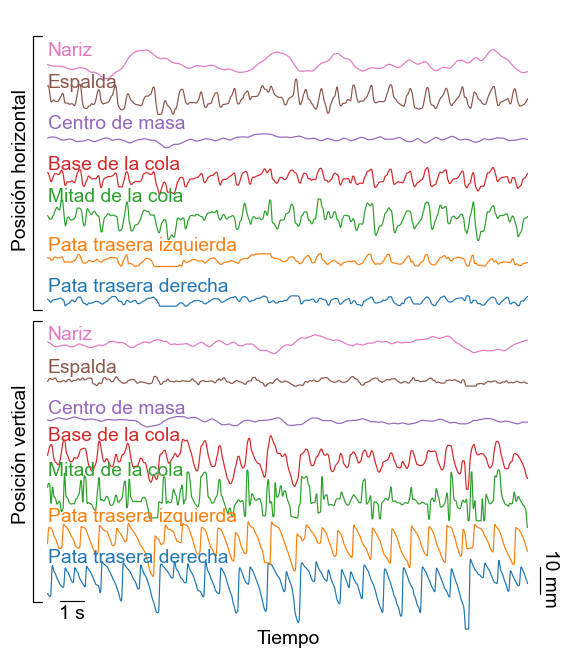

In [39]:
begin, end = 7500, 9500
plt.figure(figsize=(10, 12))
center_xys = xys[:, orden_marcadores_tesis]
center_xys -= np.mean(center_xys, axis=0)
show_xys = center_xys[:, :, 1]
show_xys = show_xys[:, ::-1]
for i, nom in enumerate(nombres_marcadores_tesis[::-1]):
    plt.plot(show_xys[begin:end, i] + i * 15, color=colores_marcadores_tesis[i])
    if nom == "Nariz":
        delta = 2
    elif nom in ["Espalda", "Centro de masa"]:
        delta = 5
    elif nom == "Mitad de la cola":
        delta = 12
    else:
        delta = 10
    plt.text(0, i * 15 + delta, nom, color=colores_marcadores_tesis[i])
plt.gca().set_prop_cycle(None)
show_xys = center_xys[:, :, 0]
show_xys = show_xys[:, ::-1]
for i, nom in enumerate(nombres_marcadores_tesis[::-1]):
    plt.plot(show_xys[begin:end, i] + (show_xys.shape[1] + i) * 15, color=colores_marcadores_tesis[i])
    if nom == "Nariz":
        delta = 2
    elif nom in ["Espalda", "Centro de masa"]:
        delta = 5
    elif nom == "Mitad de la cola":
        delta = 8
    else:
        delta = 5
    plt.text(0, len(orden_marcadores_tesis) * 15 + i * 15 + delta, nom, color=colores_marcadores_tesis[i])
dx = (end - begin) / 40
plt.text(-1.5 * dx, 155, "Posición horizontal", va="center", ha="right", rotation=90)
plt.plot([-0.5 * dx, -1.25 * dx, -1.25 * dx, -0.5 * dx], [103, 103, 204, 204], "k")
plt.plot([end - begin + dx, end - begin + dx], [-2, 8], "k")
plt.text(end - begin + 1.1 * dx, 4, r"10 mm", va="center", ha="left", rotation=-90)
plt.text(-1.5 * dx, 50, "Posición vertical", va="center", ha="right", rotation=90)
plt.plot([-0.5 * dx, -1.25 * dx, -1.25 * dx, -0.5 * dx], [-5, -5, 99, 99], "k")
dy = 100 / 40
plt.plot([50, 150], [-2 - dy, -2 - dy], "k")
plt.text(100, -2 - 1.5 * dy, "1 s", va="top", ha="center")
plt.text(1000, -15, "Tiempo", va="top", ha="center")
plt.gca().set_axis_off()
plt.savefig(config_dodo.FIG_PATH / "Steps and Poses" / "posiciones.pdf", bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Steps and Poses" / "posiciones.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [26]:
orden_ang_tesis = np.arange(ang.shape[1])
orden_ang_tesis[[0, 1]] = [2, 3]
nombres_ang_tesis = [
    "Pata trasera derecha",
    "Pata trasera derecha",
    "Pata trasera izquierda",
    "Pata trasera izquierda",
    "Patas traseras",
    "Cola",
    "Espalda",
    "Espalda",
    "Nariz",
    "Nariz",
]
tripletes_ang_tesis = [
    "(b c g)",  # right hindpaw
    "(c g b)",  # right hindpaw
    "(b c f)",  # left hindpaw
    "(c f b)",  # left hindpaw
    "(f c g)",  # cm hindpaws
    "(c d e)",  # tail
    "(d c b)",  # back
    "(c b d)",  # back
    "(b a c)",  # nose
    "(c b a)",  # nose
]
colores_ang_tesis = cm.tab10(np.linspace(0, 1, 10))

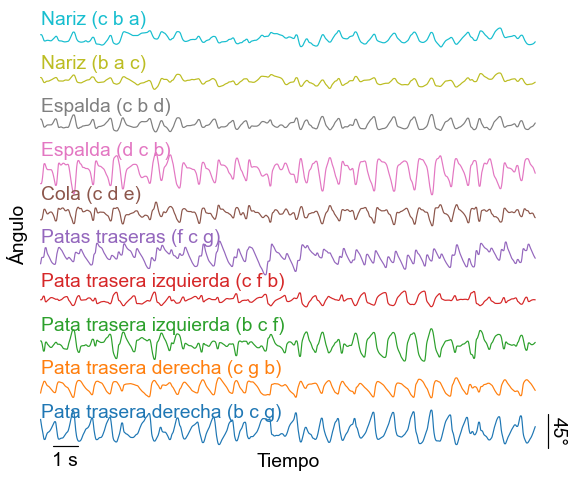

In [28]:
begin, end = 7500, 9500
plt.figure(figsize=(10, 8.5))
show_ang = ang[:, orden_ang_tesis]
# center_ang -= np.mean(center_ang, axis=0)
# show_ang = center_ang[:, :, 1]
# show_ang = show_ang[:, ::-1]
show_ang = np.copy(ang)
for i, nom in enumerate(nombres_ang_tesis):
    trip = tripletes_ang_tesis[i]
    plt.plot(show_ang[begin:end, i] + i - np.pi, color=colores_ang_tesis[i])
    plt.text(0, i + 0.3, nom + " " + trip, color=colores_ang_tesis[i])
dx = (end - begin) / 40
plt.text(-dx, 4.5, "Ángulo", va="center", ha="right", rotation=90)
lim = 45 / 180 * np.pi * 0.5
plt.plot([end - begin + dx, end - begin + dx], [-lim, lim], "k")
plt.text(end - begin + 1.1 * dx, 0, "45°", va="center", ha="left", rotation=-90)
dy = 10 / 40
plt.plot([50, 150], [-0.1 - dy, -0.1 - dy], "k")
plt.text(100, -0.1 - 1.5 * dy, "1 s", va="top", ha="center")
plt.text(1000, -0.5, "Tiempo", va="top", ha="center")
plt.gca().set_axis_off()
plt.savefig(config_dodo.FIG_PATH / "Joint Angles" / "angulos.pdf", bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Joint Angles" / "angulos.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [6]:
def _prepare_data_corr_plot(x, lags, zero=True):
    zero = bool(zero)
    irregular = False if zero else True
    if lags is None:
        nobs = x.shape[0]
        lim = min(int(np.ceil(10 * np.log10(nobs))), nobs - 1)
        lags = np.arange(not zero, lim + 1)
    elif np.isscalar(lags):
        lags = np.arange(not zero, int(lags) + 1)
    else:
        irregular = True
        lags = np.asanyarray(lags).astype(int)
    nlags = lags.max(0)
    return lags, nlags, irregular

def get_tau(x, lags, alpha):
    lags, nlags, irregular = _prepare_data_corr_plot(x=x, lags=lags)
    acf_x, confint = sm.tsa.stattools.acf(x, nlags=nlags, alpha=alpha)
    if irregular:
        acf_x = acf_x[lags]
        if confint is not None:
            confint = confint[lags]
    if confint is not None:
        if lags[0] == 0:
            lags = lags[1:]
            confint = confint[1:]
            acf_x = acf_x[1:]
        lags = lags.astype(float)
        lags[0] -= 0.5
        lags[-1] += 0.5
    tau = np.where(confint[:, 0] < 0)[0][0]
    return tau
    
orden = {
    0: "mu_y1",
    2: "mu_y2",
    4: "mu_amp",
    6: "mu_dy_max",
    8: "mu_abs_delta_phi",
    10: "mu_freq",
    1: "sigma_y1",
    3: "sigma_y2",
    5: "sigma_amp",
    7: "sigma_dy_max",
    9: "sigma_abs_delta_phi",
    11: "sigma_freq",
    12: "event_y1",
    13: "event_y2",
    14: "event_amp",
    15: "event_dy_max",
    16: "event_abs_delta_phi",
    17: "event_freq",
    22: "x_other_nose",
    21: "x_other_back",
    23: "x_center_of_mass",
    20: "x_other_tail",
    18: "x_paws_diff",
    19: "x_paws_mean",
    28: "y_other_nose",
    27: "y_other_back",
    29: "y_center_of_mass",
    26: "y_other_tail",
    24: "y_paws_diff",
    25: "y_paws_mean",
}
lws = [2] * 12 + [1] * 6 + [0.5] * 12
colors = cm.tab10(np.linspace(0, 1, 10))
stp_feats = [
    "mín",
    "máx",
    "amp",
    "vel",
    "des",
    "fre",
]
stp_markers = [
    "nar",
    "esp",
    "bas",
    "cen",
    "dif",
    "pro",
]
labels = stp_feats * 3 + stp_markers * 2
stp_nombres = [
    r"Promedio $\hat{\mu}_\xi$",
    r"Desviación $\hat{\sigma}_\xi$",
    r"Evento $\xi$",
    r"Coordenada $x$",
    r"Coordenada $y$",
]
ss = stp_scaler.transform(stp)[:, list(orden.keys())]
taus = []
lags = 10000
alpha = 0.001
for i in range(stp.shape[1]):
    taus.append(get_tau(ss[:, i], lags, alpha))

/home/alvaro/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


/tmp/ipykernel_94832/888721015.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))


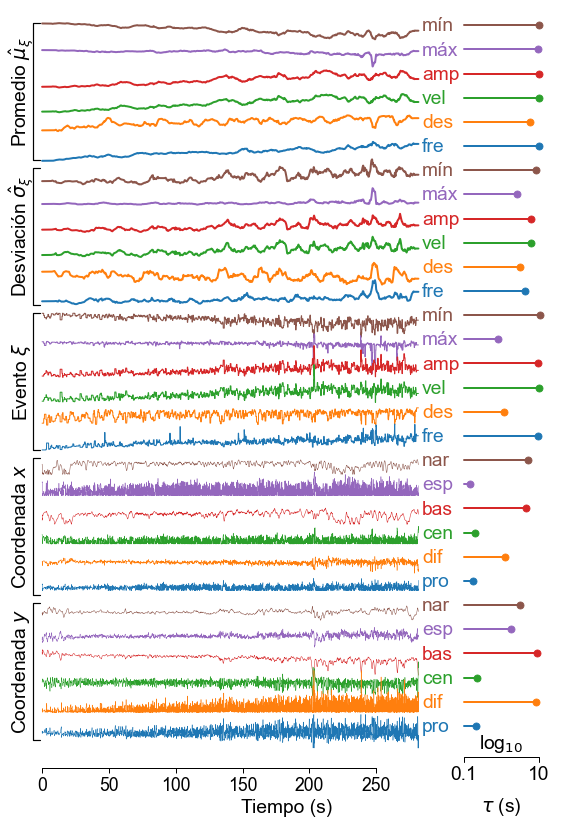

In [7]:
plt.figure(figsize=(10, 14))
ss = stp_scaler.transform(stp)[:, list(orden.keys())]
dy = 5
for i in range(stp.shape[1]):
    plt.plot(ss[:, i] + (stp.shape[1] - i) * dy, lw=lws[i], c=colors[5 - i%6])
    plt.text(len(ss) * 1.01, (stp.shape[1] - i) * dy, labels[i], color=colors[5 - i%6])
dx = len(ss) * 0.05
for i in range(0, stp.shape[1], 6):
    plt.plot([-0.1 * dx, -0.5 * dx, -0.5 * dx, -0.1 * dx], [(stp.shape[1] - i + 0.5 - 0.175) * dy] * 2 + [(stp.shape[1] - i - 6 + 0.5 + 0.175) * dy] * 2, "k")
    plt.text(-1.1 * dx, (stp.shape[1] - i - 2.5) * dy, stp_nombres[i // 6], rotation=90, va="center", ha="center")
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.xlabel("Tiempo (s)")
sns.despine(trim=True)
t0 = len(ss) * 1.12
tscale = len(ss) * 0.2
tmax = 1000
tmin = 10
for i in range(stp.shape[1]):
    plt.plot(
        # [t0, t0 + taus[i] / tmax * tscale], [(stp.shape[1] - i + 0.25) * dy] * 2,
        [t0, t0 + (np.log10(taus[i]) - np.log10(tmin)) / (np.log10(tmax) - np.log10(tmin)) * tscale], [(stp.shape[1] - i + 0.25) * dy] * 2,
        lw=2, c=colors[5 - i%6]
    )
    plt.scatter(
        # t0 + taus[i] / tmax * tscale, (stp.shape[1] - i + 0.25) * dy,
        t0 + (np.log10(taus[i]) - np.log10(tmin)) / (np.log10(tmax) - np.log10(tmin)) * tscale, (stp.shape[1] - i + 0.25) * dy,
        color=colors[5 - i%6], s=50
    )
plt.plot(
    [t0, t0, t0 + tscale, t0 + tscale], [-0.25 * dy, -0.05 * dy, -0.05 * dy, -0.25 * dy],
    lw=1, c="k"
)
plt.text(t0 + tscale * 0.5, 0.5 * dy, r"log$_{10}$", va="center", ha="center")
plt.text(t0, -0.4 * dy, "0.1", va="top", ha="center")
plt.text(t0 + tscale, -0.4 * dy, "10", va="top", ha="center")
plt.text(t0 + tscale * 0.5, -2.1 * dy, r"$\tau$ (s)", va="center", ha="center")
plt.gca().tick_params(bottom=True, left=False, labelbottom=True, labelleft=False)
plt.gca().spines["left"].set_visible(False)
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.ylim(-0.5 * dy, (stp.shape[1] + 1) * dy)
plt.savefig(config_dodo.FIG_PATH / "Steps and Poses" / "caracteristicas_pasos_poses.pdf", bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Steps and Poses" / "caracteristicas_pasos_poses.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [236]:
print(np.min(taus), np.max(taus))

15 1071


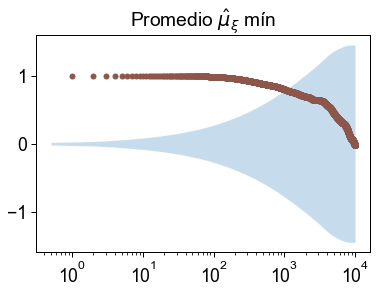

In [241]:
ss = stp_scaler.transform(stp)[:, list(orden.keys())]
# for i in range(stp.shape[1]):
for i in [0]:
    sm.graphics.tsa.plot_acf(
        ss[:, i], lags=10000, use_vlines=False, c=colors[5 - i%6], title=stp_nombres[i // 6] + " " + labels[i],
        alpha=0.001,
    )
    plt.xscale("log")
    plt.show()
    plt.close()

In [44]:
step_statistics

,hindpaw,mu_y1,sigma_y1,mu_y2,sigma_y2,mu_d2y1,sigma_d2y1,mu_d2y2,sigma_d2y2,mu_dy_max,...,sigma_isi_dy_max,mu_delta_phi,sigma_delta_phi,mu_abs_delta_phi,sigma_abs_delta_phi,mu_amp,sigma_amp,mu_freq,sigma_freq,dy_baseline
0,left,26.355068,3.266659,32.48309,0.949637,1576.289215,1209.773052,-2412.358324,1606.582978,81.012895,...,99.808781,0.077426,0.277856,0.185777,0.121203,6.512730,3.806630,0.666104,0.330983,0.0
1,left,26.355068,3.266659,32.48309,0.949637,1576.289215,1209.773052,-2412.358324,1606.582978,81.012895,...,99.808781,0.077426,0.277856,0.185777,0.121203,6.512730,3.806630,0.666104,0.330983,0.0
2,left,26.355068,3.266659,32.48309,0.949637,1576.289215,1209.773052,-2412.358324,1606.582978,81.012895,...,99.808781,0.077426,0.277856,0.185777,0.121203,6.512730,3.806630,0.666104,0.330983,0.0
3,left,26.355068,3.266659,32.48309,0.949637,1576.289215,1209.773052,-2412.358324,1606.582978,81.012895,...,99.808781,0.077426,0.277856,0.185777,0.121203,6.512730,3.806630,0.666104,0.330983,0.0
4,left,26.355068,3.266659,32.48309,0.949637,1576.289215,1209.773052,-2412.358324,1606.582978,81.012895,...,99.808781,0.077426,0.277856,0.185777,0.121203,6.512730,3.806630,0.666104,0.330983,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56289,right,13.997318,7.553504,31.18776,1.927941,8322.903282,2882.137664,-8373.230960,2671.666686,269.456117,...,15.715584,0.106703,0.556992,0.397814,0.103716,16.107692,6.197668,2.670024,1.035223,0.0
56290,right,13.997318,7.553504,31.18776,1.927941,8322.903282,2882.137664,-8373.230960,2671.666686,269.456117,...,15.715584,0.106703,0.556992,0.397814,0.103716,16.107692,6.197668,2.670024,1.035223,0.0
56291,right,13.997318,7.553504,31.18776,1.927941,8322.903282,2882.137664,-8373.230960,2671.666686,269.456117,...,15.715584,0.106703,0.556992,0.397814,0.103716,16.107692,6.197668,2.670024,1.035223,0.0
56292,right,13.997318,7.553504,31.18776,1.927941,8322.903282,2882.137664,-8373.230960,2671.666686,269.456117,...,15.715584,0.106703,0.556992,0.397814,0.103716,16.107692,6.197668,2.670024,1.035223,0.0


In [5]:
step_events

,hindpaw,t_y1,t_y2,y1,y2,t_d2y1,t_d2y2,d2y1,d2y2,t_dy_max,dy_max,isi_dy_max,amp,freq,delta_phi,abs_delta_phi
0,left,21,34,22.814852,30.048738,28,34,2001.438727,-3414.417695,31,98.188386,119,7.233887,0.840336,0.183099,0.183099
1,left,140,153,23.162420,29.764267,147,152,2905.606289,-3215.714204,150,104.138441,119,6.601847,0.840336,0.345070,0.345070
2,left,326,339,15.797909,27.193721,333,338,3964.206508,-4785.547773,335,161.537148,185,11.395812,0.540541,0.081081,0.081081
3,left,516,530,12.665507,32.559090,523,528,8304.705248,-8695.287142,526,310.032672,191,19.893583,0.523560,-0.111111,0.111111
4,left,719,733,11.352114,24.870850,726,731,5178.708557,-6000.533311,728,209.040804,202,13.518736,0.495050,0.149425,0.149425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,right,22199,22231,-7.025455,2.301170,22197,22232,2025.481354,-4910.136804,22228,52.948376,88,9.326625,1.136364,0.195652,0.195652
573,right,22255,22292,-16.343865,24.117078,22262,22286,1237.122209,-816.146848,22285,314.119997,57,40.460943,1.754386,0.500000,0.500000
574,right,22328,22337,2.133632,20.264748,22330,22336,8939.354532,-9560.460584,22333,311.324559,48,18.131116,2.083333,-0.243243,0.243243
575,right,22371,22380,-2.343756,31.141550,22374,22379,17955.083308,-18365.272600,22376,581.663516,43,33.485306,2.325581,-0.081081,0.081081


22597
(22597,)
(573,)
2.535734832057353
1


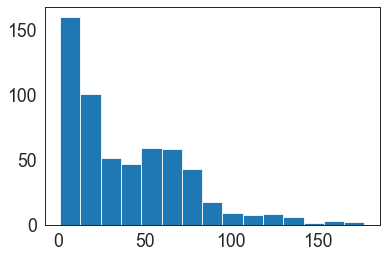

{1: 11, 2: 17, 3: 12, 4: 12, 5: 15, 6: 14, 7: 9, 8: 21, 9: 15, 10: 11, 11: 12, 12: 11, 13: 14, 14: 12, 15: 8, 16: 6, 17: 6, 18: 6, 19: 10, 20: 12, 21: 8, 22: 9, 23: 6, 24: 4, 25: 2, 26: 3, 27: 6, 28: 10, 29: 3, 30: 2, 31: 5, 32: 6, 33: 4, 34: 6, 35: 3, 36: 1, 37: 9, 38: 3, 39: 6, 40: 2, 41: 7, 42: 4, 43: 1, 44: 5, 45: 2, 46: 3, 47: 5, 48: 6, 49: 6, 50: 2, 51: 6, 52: 5, 53: 4, 54: 5, 55: 2, 56: 5, 57: 6, 58: 4, 59: 8, 60: 7, 61: 4, 62: 2, 63: 4, 64: 5, 65: 6, 66: 5, 67: 5, 68: 5, 69: 5, 70: 6, 71: 4, 72: 4, 73: 3, 74: 6, 75: 4, 76: 4, 77: 4, 78: 2, 79: 1, 80: 4, 81: 3, 82: 4, 83: 4, 84: 3, 86: 1, 87: 1, 88: 2, 89: 3, 90: 1, 91: 2, 92: 2, 93: 1, 94: 1, 96: 1, 97: 1, 99: 1, 100: 1, 101: 1, 103: 1, 104: 1, 105: 1, 106: 1, 108: 1, 109: 3, 110: 1, 117: 2, 120: 1, 121: 1, 124: 2, 128: 1, 129: 1, 130: 2, 132: 1, 133: 1, 134: 1, 135: 2, 136: 1, 146: 1, 154: 1, 163: 1, 165: 1, 172: 1, 177: 1}
(3235,)
14.316059653936364


In [6]:
latency_sum = 0


np.random.seed(42)
print(latency)
frames = np.arange(latency)
step_frames = step_events["t_dy_max"].append(pd.Series([0, latency])).drop_duplicates().to_numpy()
step_frames = step_frames[step_frames <= latency]
step_frames.sort()
step_frames_dif = np.diff(step_frames)
num_between = 2 # entre 7 y 11%
num_between = 3 # entre 10 y 15%
num_between = 4 # entre 12 y 18%
num_between = 5 # entre 14 y 21%
# num_between = 6 # entre 16 y 25%
# num_between = 7 # entre 18 y 27% depende de la sincronizacion entre patas (mayor desfasaje, mayor porcentaje)
# num_between = 8 # entre 20 y 30%
# num_between = 9 # entre 22 y 33%
# num_between = 10 # entre 25 y 36%
# num_between = 15 # entre 34 y 49%
print(frames.shape)
print(step_frames.shape)
print(len(step_frames) / len(frames) * 100.0)
print(step_frames_dif.min())
plt.hist(step_frames_dif, bins="auto")
plt.show()
plt.close()
unique, counts = np.unique(step_frames_dif, return_counts=True)
print(dict(zip(unique, counts)))
subsample = [[0], ]
for i in range(len(step_frames) - 1):
    # if step_frames_dif[i] > 1:
    #     frames_between = np.random.choice(
    #         np.arange(step_frames[i] + 1, step_frames[i + 1]),
    #         size=np.minimum(num_between, step_frames_dif[i]),
    #         replace=False,
    #     )
    #     frames_between.sort()
    #     subsample.append(frames_between)
    frames_between = np.random.choice(
        np.arange(step_frames[i] + 1, step_frames[i + 1]),
        size=np.minimum(num_between, step_frames_dif[i] - 1),
        replace=False,
    )
    frames_between.sort()
    subsample.append(frames_between)
    subsample.append([step_frames[i + 1]])
subsample = np.concatenate(subsample)
print(subsample.shape)
print(len(subsample) / len(frames) * 100.0)

22597
(22597,)
(573,)
2.535734832057353
1


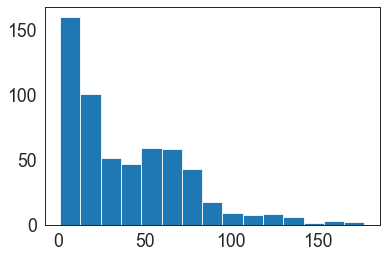

{1: 11, 2: 17, 3: 12, 4: 12, 5: 15, 6: 14, 7: 9, 8: 21, 9: 15, 10: 11, 11: 12, 12: 11, 13: 14, 14: 12, 15: 8, 16: 6, 17: 6, 18: 6, 19: 10, 20: 12, 21: 8, 22: 9, 23: 6, 24: 4, 25: 2, 26: 3, 27: 6, 28: 10, 29: 3, 30: 2, 31: 5, 32: 6, 33: 4, 34: 6, 35: 3, 36: 1, 37: 9, 38: 3, 39: 6, 40: 2, 41: 7, 42: 4, 43: 1, 44: 5, 45: 2, 46: 3, 47: 5, 48: 6, 49: 6, 50: 2, 51: 6, 52: 5, 53: 4, 54: 5, 55: 2, 56: 5, 57: 6, 58: 4, 59: 8, 60: 7, 61: 4, 62: 2, 63: 4, 64: 5, 65: 6, 66: 5, 67: 5, 68: 5, 69: 5, 70: 6, 71: 4, 72: 4, 73: 3, 74: 6, 75: 4, 76: 4, 77: 4, 78: 2, 79: 1, 80: 4, 81: 3, 82: 4, 83: 4, 84: 3, 86: 1, 87: 1, 88: 2, 89: 3, 90: 1, 91: 2, 92: 2, 93: 1, 94: 1, 96: 1, 97: 1, 99: 1, 100: 1, 101: 1, 103: 1, 104: 1, 105: 1, 106: 1, 108: 1, 109: 3, 110: 1, 117: 2, 120: 1, 121: 1, 124: 2, 128: 1, 129: 1, 130: 2, 132: 1, 133: 1, 134: 1, 135: 2, 136: 1, 146: 1, 154: 1, 163: 1, 165: 1, 172: 1, 177: 1}
[   15    23    27 ... 22482 22562 22587]
(1677,)
(1677,)
7.421339115811833


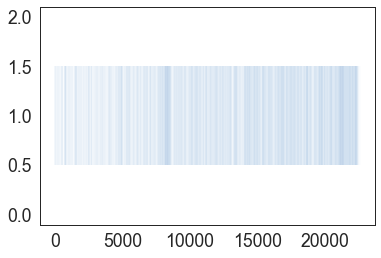

In [7]:
"""Randomize step frames too."""
latency_sum = 0
np.random.seed(42)
print(latency)
frames = np.arange(latency)
step_frames = step_events["t_dy_max"].append(pd.Series([0, latency])).drop_duplicates().to_numpy()
step_frames = step_frames[step_frames <= latency]
step_frames.sort()
step_frames_dif = np.diff(step_frames)
num_between = 2 # entre 7 y 11%
# num_between = 3 # entre 10 y 15%
# num_between = 4 # entre 12 y 18%
# num_between = 5 # entre 14 y 21%
# num_between = 6 # entre 16 y 25%
# num_between = 7 # entre 18 y 27% depende de la sincronizacion entre patas (mayor desfasaje, mayor porcentaje)
# num_between = 8 # entre 20 y 30%
# num_between = 9 # entre 22 y 33%
# num_between = 10 # entre 25 y 36%
# num_between = 15 # entre 34 y 49%
print(frames.shape)
print(step_frames.shape)
print(len(step_frames) / len(frames) * 100.0)
print(step_frames_dif.min())
plt.hist(step_frames_dif, bins="auto")
plt.show()
plt.close()
unique, counts = np.unique(step_frames_dif, return_counts=True)
print(dict(zip(unique, counts)))
subsample = []
for i in range(len(step_frames) - 1):
    frames_between = np.random.choice(
        np.arange(step_frames[i], step_frames[i + 1]),
        size=np.minimum(num_between + 1, step_frames_dif[i]),
        replace=False,
    )
    frames_between.sort()
    subsample.append(frames_between)
subsample = np.concatenate(subsample)
print(subsample)
print(subsample.shape)
print(np.unique(subsample).shape)
print(len(subsample) / len(frames) * 100.0)
plt.eventplot(subsample, lw=0.25, alpha=0.1)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


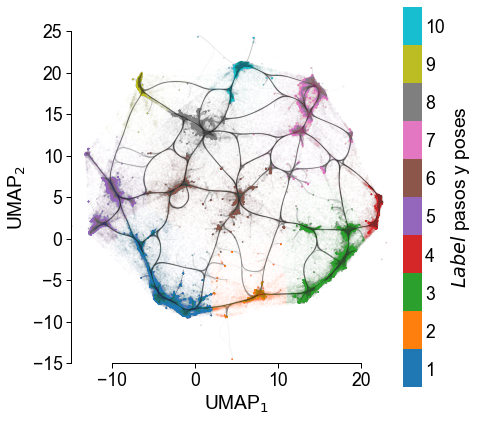

In [250]:
color = label_stp_all[::config.EDG_SUBSAMPLE_EVERY]
label = r"$Label$ pasos y poses"
save_name = "conectividad_stp.png"
extent = list(config.WAT_EMB_STP_EDG) * 2
dpi = 600
width = 7 * dpi
height = 7 * dpi
ax = hammer_connectivity(
    edges=edg_stp,
    extent=extent,
    dpi=dpi,
    width=width,
    height=height,
)
xmin = extent[0]
xmax = extent[1]
ymin = extent[2]
ymax = extent[3]
ax.scatter(
    *out_stp_all[::config.EDG_SUBSAMPLE_EVERY].T,
    s=1,
    alpha=0.01,
    c=color,
    cmap="tab10",
    zorder=15,
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Steps and Poses" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [8]:
def get_single_entropy_hist_labels(key, label_key, data, hist_bins):
    m, d, t = key
    trial_labels = data.query(r"mouse==@m & day==@d & trial==@t")[label_key].to_numpy()
    hist_trial_labels = np.histogram(a=trial_labels, bins=hist_bins)[0] / len(
        trial_labels
    )
    entropy_labels = entropy(hist_trial_labels)
    return entropy_labels, hist_trial_labels

tmax = 10000
mask = seq_data_stp.local_idx <= tmax
short_data = []
hist_bins = np.arange(0.5, 11.5)
for key in config_dodo.KEY_LIST:
    ent, p = get_single_entropy_hist_labels(
        key, "label_stp", seq_data_stp.loc[mask], hist_bins
    )
    p = p * 100
    dat = {"mouse": key[0], "day": key[1], "trial": key[2], "entropy_stp": ent}
    dat.update(dict(zip([f"p{i + 1}_stp" for i in range(len(p))], p)))
    short_data.append(dat)
short_data = pd.DataFrame(short_data)
mouse_performance_dict = {m: "lp" for m in config_dodo.LP_MOUSE_LIST}
mouse_performance_dict.update({m: "hp" for m in config_dodo.HP_MOUSE_LIST})
short_data["performance"] = short_data["mouse"].map(mouse_performance_dict)

hist_stp_all = np.histogram(a=seq_data_stp["label_stp"], bins=hist_bins)[0] / len(seq_data_stp)
ent_stp_all = entropy(hist_stp_all)

ANOVA
hp 0.16268161061369946
lp 0.03098764824476231
Paired t-test
D1 0.5924975797702395
D2 0.023477022663665602
D3 0.19063531398313271
D4 0.19187830055837418
D5 0.11822193579326963


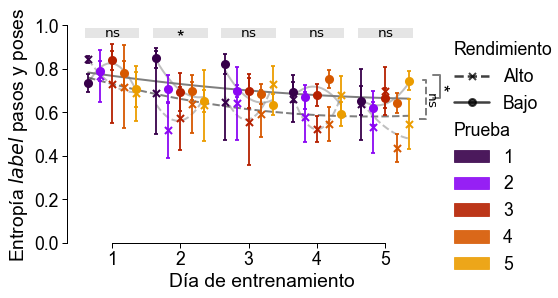

In [11]:
from scipy.stats import f_oneway, ttest_rel
from scipy.optimize import curve_fit

def pvalue_to_stars(pvalue):
    """Format pvalue into stars or ns"""
    text = ""
    if pvalue <= 0.05:
        text += "*"
        if pvalue <= 0.01:
            text += "*"
            if pvalue <= 0.001:
                text += "*"
                if pvalue <= 0.0001:
                    text += "*"
    else:
        text = r"$^{\mathrm{ns}}$"
    return text

def plot_pvalue_vertical(ax, pvalue, x, ylims, w, ls, lw, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    ymin, ymax = ylims
    ax.plot([x, x + w, x + w, x], [ymin, ymin, ymax, ymax], ls=ls, lw=lw, c=c, alpha=alpha)
    ax.annotate(text=text, xy=(x + w, 0.5 * (ymin + ymax)), zorder=10, ha="center", va="center", rotation=-90)

def plot_pvalue_horizontal(ax, pvalue, y, xlims, h, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    xmin, xmax = xlims
    rect = mpatches.Rectangle((xmin, y), xmax - xmin, h, linewidth=0.0, edgecolor="none", facecolor=c, alpha=alpha)
    ax.add_patch(rect)
    ax.annotate(text=text, xy=(0.5 * (xmin + xmax), y), zorder=10, ha="center", va="center")

def my_poly(x, *p):
    """my polynomial function, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def my_poly_plot(x, *p):
    """my polynomial function to plot, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def fit_poly_plot(deg, t, mu, sigma):
    """fit a deg order polynomial to t_ref mu_ref"""
    popt, _ = curve_fit(my_poly, t, mu, sigma=sigma, absolute_sigma=True, p0=[1] * (deg + 1))
    return popt

box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
pos = [pos_d + pos_t for pos_d, pos_t in product(pos_dias, pos_trials)]
color_trials = plt.get_cmap("gnuplot")([0.05, 0.3, 0.5, 0.7, 0.85], len(config_dodo.DAY_LIST))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}

metricas_grupos_intertrial = short_data.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = short_data.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)

fig = plt.figure(figsize=(7, 4))
for t, p in product(config_dodo.TRIAL_LIST, ["lp", "hp"]):
    i = t - 1
    values = mean.query("trial == @t and performance == @p")["entropy_stp"].values / ent_stp_all
    bars = error.query("trial == @t and performance == @p")["entropy_stp"].values / ent_stp_all
    plt.scatter(
        x=pos[i::5], y=values,
        marker=marker_perf[p], color=color_trials[i], s=50, linewidths=2, alpha=1.0, zorder=10
    )
    plt.errorbar(
        x=pos[i::5], y=values, yerr=bars,
        color="none", ecolor=color_trials[i], capsize=2, elinewidth=2, capthick=2, alpha=0.9, zorder=10
    )
for p in ["lp", "hp"]:
    values_interdia = mean_interdia.query("performance == @p")["entropy_stp"].values / ent_stp_all
    bars_interdia = error_interdia.query("performance == @p")["entropy_stp"].values / ent_stp_all
    popt = fit_poly_plot(deg=2, t=pos_dias, mu=values_interdia, sigma=bars_interdia)
    plt.plot(pos, my_poly_plot(pos, *popt), color="k", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)
    for d in config_dodo.DAY_LIST:
        values = mean.query("day == @d and performance == @p")["entropy_stp"].values / ent_stp_all
        bars = error.query("day == @d and performance == @p")["entropy_stp"].values / ent_stp_all
        pos_d = d + pos_trials
        popt = fit_poly_plot(deg=2, t=pos_d, mu=values, sigma=bars)
        pos_d = np.linspace(pos_d[0], pos_d[-1], 16)
        plt.plot(pos_d, my_poly_plot(pos_d, *popt), color="0.5", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)

"""Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
ax = plt.gca()
xlims = ax.get_xlim()
ylims = ax.get_ylim()
print("ANOVA")
dx = 0.0
for p in ["hp", "lp"]:
    # stat, pvalue = f_oneway(*[short_data.query("day == @d and trial == @t and performance == @p")["entropy_stp"].values / ent_stp_all for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
    stat, pvalue = f_oneway(*[short_data.query("day == @d and performance == @p")["entropy_stp"].values / ent_stp_all for d in config_dodo.DAY_LIST])
    plot_pvalue_vertical(
        ax=ax, pvalue=pvalue, x=5.5 + dx,
        ylims=(mean_interdia.query("performance == @p")["entropy_stp"].min() / ent_stp_all, mean_interdia.query("performance == @p")["entropy_stp"].max()  / ent_stp_all),
        w=0.1, ls=ls_perf[p], lw=2, c="k", alpha=0.5,
    )
    dx += 0.2
    print(p, pvalue)
"""Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
print("Paired t-test")
for d in config_dodo.DAY_LIST:
    stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")["entropy_stp"].values / ent_stp_all for p in ["lp", "hp"]])
    plot_pvalue_horizontal(
        ax=ax, pvalue=pvalue, y=ylims[1],
        xlims=(d - 0.4, d + 0.4),
        h=(ylims[1] - ylims[0]) * 0.075, c="0.5", alpha=0.2,
    )
    print(f"D{d}", pvalue)

plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel(r"Entropía $label$ pasos y poses")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2.5, ls=ls_perf[p], c="k", alpha=0.75) for p in ["hp", "lp"]]
labels += ["Alto", "Bajo"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
handles += [mpatches.Patch(color=c, alpha=0.9) for c in color_trials]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
plt.ylim(0, 1)
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "stp/entropia_stp.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [7]:
(config_dodo.FIG_PATH / "Metrics" / "stp").mkdir(parents=True, exist_ok=True)
from scipy.stats import f_oneway, ttest_rel
from scipy.optimize import curve_fit

p_keys = [f"p{i + 1}_stp" for i in range(10)]

def pvalue_to_stars(pvalue):
    """Format pvalue into stars or ns"""
    text = ""
    if pvalue <= 0.05:
        text += "*"
        if pvalue <= 0.01:
            text += "*"
            if pvalue <= 0.001:
                text += "*"
                if pvalue <= 0.0001:
                    text += "*"
    else:
        text = r"$^{\mathrm{ns}}$"
    return text

def plot_pvalue_vertical(ax, pvalue, x, ylims, w, ls, lw, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    ymin, ymax = ylims
    ax.plot([x, x + w, x + w, x], [ymin, ymin, ymax, ymax], ls=ls, lw=lw, c=c, alpha=alpha)
    ax.annotate(text=text, xy=(x + w, 0.5 * (ymin + ymax)), zorder=10, ha="center", va="center", rotation=-90)

def plot_pvalue_horizontal(ax, pvalue, y, xlims, h, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    xmin, xmax = xlims
    rect = mpatches.Rectangle((xmin, y), xmax - xmin, h, linewidth=0.0, edgecolor="none", facecolor=c, alpha=alpha)
    ax.add_patch(rect)
    ax.annotate(text=text, xy=(0.5 * (xmin + xmax), y), zorder=10, ha="center", va="center")

def my_poly(x, *p):
    """my polynomial function, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def my_poly_plot(x, *p):
    """my polynomial function to plot, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def fit_poly_plot(deg, t, mu, sigma):
    """fit a deg order polynomial to t_ref mu_ref"""
    popt, _ = curve_fit(my_poly, t, mu, sigma=sigma, absolute_sigma=True, p0=[1] * (deg + 1))
    return popt

box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
pos = [pos_d + pos_t for pos_d, pos_t in product(pos_dias, pos_trials)]
color_trials = plt.get_cmap("gnuplot")([0.05, 0.3, 0.5, 0.7, 0.85], len(config_dodo.DAY_LIST))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}

metricas_grupos_intertrial = short_data.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = short_data.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)

for l, p_key in enumerate(p_keys):
    fig = plt.figure(figsize=(7, 3.75))
    for t, p in product(config_dodo.TRIAL_LIST, ["lp", "hp"]):
        i = t - 1
        values = mean.query("trial == @t and performance == @p")[p_key].values
        bars = error.query("trial == @t and performance == @p")[p_key].values
        plt.scatter(
            x=pos[i::5], y=values,
            marker=marker_perf[p], color=color_trials[i], s=50, linewidths=2, alpha=1.0, zorder=10
        )
        plt.errorbar(
            x=pos[i::5], y=values, yerr=bars,
            color="none", ecolor=color_trials[i], capsize=2, elinewidth=2, capthick=2, alpha=0.9, zorder=10
        )
    for p in ["lp", "hp"]:
        values_interdia = mean_interdia.query("performance == @p")[p_key].values
        bars_interdia = error_interdia.query("performance == @p")[p_key].values
        popt = fit_poly_plot(deg=2, t=pos_dias, mu=values_interdia, sigma=bars_interdia + 1e-6)
        plt.plot(pos, my_poly_plot(pos, *popt), color="k", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)
        for d in config_dodo.DAY_LIST:
            values = mean.query("day == @d and performance == @p")[p_key].values
            bars = error.query("day == @d and performance == @p")[p_key].values
            pos_d = d + pos_trials
            popt = fit_poly_plot(deg=2, t=pos_d, mu=values, sigma=bars + 1e-6)
            pos_d = np.linspace(pos_d[0], pos_d[-1], 16)
            plt.plot(pos_d, my_poly_plot(pos_d, *popt), color="0.5", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)

    """Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
    ax = plt.gca()
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    # print("ANOVA")
    dx = 0.0
    for p in ["hp", "lp"]:
        # stat, pvalue = f_oneway(*[short_data.query("day == @d and trial == @t and performance == @p")[p_key].values for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
        stat, pvalue = f_oneway(*[short_data.query("day == @d and performance == @p")[p_key].values for d in config_dodo.DAY_LIST])
        plot_pvalue_vertical(
            ax=ax, pvalue=pvalue, x=5.5 + dx,
            ylims=(mean_interdia.query("performance == @p")[p_key].min(), mean_interdia.query("performance == @p")[p_key].max() ),
            w=0.1, ls=ls_perf[p], lw=2, c="k", alpha=0.5,
        )
        dx += 0.2
        # print(p, pvalue)
    """Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
    # print("Paired t-test")
    for d in config_dodo.DAY_LIST:
        stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")[p_key].values for p in ["lp", "hp"]])
        plot_pvalue_horizontal(
            ax=ax, pvalue=pvalue, y=ylims[1],
            xlims=(d - 0.4, d + 0.4),
            h=(ylims[1] - ylims[0]) * 0.075, c="0.5", alpha=0.2,
        )
        # print(f"D{d}", pvalue)

    # plt.xticks(pos_dias, config_dodo.DAY_LIST)
    # plt.xlabel("Día de entrenamiento")
    # plt.ylabel(r"Probabilidad $label$" f" {l + 1}\n" + r"$wavelets$ (%)")
    # handles = []
    # labels = []
    # title_1 = "Rendimiento"
    # title_2 = "Prueba"
    # handles += [Line2D([], [], color="none")]
    # labels += [title_1]
    # handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2.5, ls=ls_perf[p], c="k", alpha=0.75) for p in ["hp", "lp"]]
    # labels += ["Alto", "Bajo"]
    # handles += [Line2D([], [], color="none")]
    # labels += [title_2]
    # handles += [mpatches.Patch(color=c, alpha=0.9) for c in color_trials]
    # labels += [str(t) for t in config_dodo.TRIAL_LIST]
    # leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
    # for item, label in zip(leg.legendHandles, leg.texts):
    #     if label._text in [title_1, title_2]:
    #         width = item.get_window_extent(fig.canvas.get_renderer()).width
    #         label.set_ha("left")
    #         label.set_position((-1.4 * width, 0.0))
    # leg._legend_handle_box.width = 90.0
    ylims = ax.get_ylim()
    dy = ylims[1] * 0.05
    plt.ylim(-dy, ylims[1])
    sns.despine(trim=True)
    """grid plot subfigure"""
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.spines["bottom"].set_visible(False)
    plt.ylabel(r"$Label$" + f" {l + 1}")
    plt.savefig(config_dodo.FIG_PATH / "Metrics" / f"stp/{p_key}.pdf", bbox_inches="tight")
    # plt.show()
    plt.close()